**Note:** running with on purpose created environment `r5py-env`<br/>
(conflicts with geopandas, still WIP)

script from here https://r5py.readthedocs.io/en/stable/notebooks/basic-usage.html

## Data import and variables/path definition

In [38]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import tracc
from r5py import TransportNetwork, TravelTimeMatrixComputer, TransitMode, LegMode
import matplotlib.pyplot as plt
sys.argv.append(["--max-memory", "8G"])


data_folder = "/Users/azanchetta/OneDrive - The Alan Turing Institute/demoland_data"


# regional level files: (require previous editing)
lsoas_centroids_file = f"{data_folder}/processed/authorities/tynewear_lsoas_centroids_wgs84.shp"
jobs_file = f"{data_folder}/processed/accessibility/bres_jobs_tynewear.csv"
gs_accesspoints_per_lsoa_file = f"{data_folder}/processed/accessibility/tynewear_gs_accesspoints_lsoas.csv"
region_lads_file = f"{data_folder}/processed/authorities/LADs_tynewear.shp" # needed in order to find gs within the regional boundaries

# national level files
gs_accesspoints_file = f"{data_folder}/raw/accessibility/OS Open Greenspace (GPKG) GB/data/opgrsp_gb.gpkg"
lsoas_boundaries_file = f"{data_folder}/raw/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3.geojson"


In [39]:
# reading in the origin/destination points shp (just for tynewear region):
centroids = gpd.read_file(lsoas_centroids_file)
centroids['id'] = centroids['LSOA21CD']
centroids.head()

# reading in land use data:
# n of jobs per lsoa from Nomis Bres
jobs_per_lsoa = pd.read_csv(jobs_file)
jobs_per_lsoa.head()
# n of access points to gs per lsoa (calculated in Qgis for a first trial)
accesspoints_per_lsoa = pd.read_csv(gs_accesspoints_per_lsoa_file)
accesspoints_per_lsoa.head()

# reading in the green space points shp (UK file):
accesspoints = gpd.read_file(gs_accesspoints_file,
                        layer = "AccessPoint")
accesspoints.head()

id                    accessType  \
0  idB91D85B1-DEE3-47D6-805A-CD6B9ACF4C4F                    Pedestrian   
1  id4A6E7947-0AFE-48E3-8D42-D4FD1EF4FDEE                    Pedestrian   
2  id2614EF8D-E649-4A9F-86F2-95E248B38AFB  Motor Vehicle And Pedestrian   
3  idCC4DDC12-0AE9-4023-A7FE-DE064614A1DC                    Pedestrian   
4  idB616B7A5-140F-4564-BDC0-A5AAF61E51AC  Motor Vehicle And Pedestrian   

                      refToGreenspaceSite                        geometry  
0  idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E  POINT (456682.070 1204040.270)  
1  idE56DE70E-A916-13A9-E053-AAEFA00A0D0E  POINT (453155.070 1204881.760)  
2  idE56DE70E-A769-13A9-E053-AAEFA00A0D0E  POINT (461466.140 1208820.310)  
3  idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E  POINT (462261.310 1208879.400)  
4  idE56DE70E-A700-13A9-E053-AAEFA00A0D0E  POINT (460892.660 1208953.160)

In [40]:
centroids.crs # wgs84
accesspoints.crs #OSGB1936

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [41]:
# extra layers needed for the analysis

# reading in the regional admin boundaries (LADs, but it should work for regional gs filtering):
lads_region = gpd.read_file(region_lads_file)
lads_region.head()

# reading in the LSOAs bpundaries
lsoas_boundaries = gpd.read_file(lsoas_boundaries_file)
lsoas_boundaries.head()

OBJECTID   LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0         1  E01000001        City of London 001A        City of London 001A   
1         2  E01000002        City of London 001B        City of London 001B   
2         3  E01000003        City of London 001C        City of London 001C   
3         4  E01000005        City of London 001E        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

    BNG_E   BNG_N      LONG       LAT    Shape__Area  Shape__Length  \
0  532129  181625 -0.097060  51.51810  157794.481079    1685.391778   
1  532480  181699 -0.091970  51.51868  164882.427628    1804.828196   
2  532245  182036 -0.095230  51.52176   42219.805717     909.223277   
3  533581  181265 -0.076280  51.51452  212682.404259    2028.654904   
4  544994  184276  0.089318  51.53876  130551.387161    1716.896118   

                               GlobalID  \
0  b12173a3-5423-4672-a5eb-f152d2345f96   
1  90274dc4-f785-4afb-95cd-7cc1fc9a2cad   
2  7e89d0ba-f186-45fb-961c-8f5ffcd03808   
3  a14c307a-874c-4862-828a-3b1486cc21ea   
4  65121a2d-3d2b-4935-9712-690f2993cfd2   

                                            geometry  
0  POLYGON ((-0.09474 51.52060, -0.09546 51.51544...  
1  POLYGON ((-0.08810 51.51941, -0.09546 51.51544...  
2  POLYGON ((-0.09453 51.52205, -0.09274 51.52139...  
3  POLYGON ((-0.07589 51.51590, -0.07394 51.51445...  
4  POLYGON ((0.09328 51.53787, 0.09363 51.53767, ...

In [42]:
lsoas_boundaries.crs # OSGB1936
lsoas_boundaries_wgs84 = lsoas_boundaries.to_crs("epsg:4326")

In [43]:
centroids.explore()

In [44]:
accesspoints_per_lsoa.n_access.dtype

dtype('int64')

In [45]:
# merging geospatial data (admin boundaries/centroids) with landuse data (jobs and greenspaces points, could be population etc)

landuse_gdf = pd.merge(centroids, # gdf file
                       jobs_per_lsoa, # info we want to add
                       how = "inner", # this allows to pick (from the nationals centroids table) only LSOAs that belong to the region (jobs file)
                       left_on = "LSOA21CD",
                       right_on = "LSOA11CD")
landuse_gdf.head()

landuse_gdf = pd.merge(landuse_gdf,
                       accesspoints_per_lsoa,
                       how = "inner",
                       left_on = "LSOA21CD",
                       right_on = "LSOA11CD")
landuse_gdf.head()

landuse_gdf.jobs = landuse_gdf.jobs.fillna(0).astype(np.int64) # removing NaN and changing type to Int
# hoping that this makes "explore" work below. NOTE: deal with this issue later on in a better way (IE clean data before importing them in python)
landuse_gdf.n_access = landuse_gdf.n_access.fillna(0).astype(np.int64)
landuse_gdf.dtypes



LSOA21CD        object
geometry      geometry
id              object
LSOA11CD_x      object
jobs             int64
LSOA11CD_y      object
n_access         int64
dtype: object

In [46]:
landuse_gdf.n_access.isnull().sum().sum() # (checking number of na in column)

0

In [47]:
landuse_gdf.explore(column="n_access",
                    cmap="plasma"
                    # style_kwds={"style_function":lambda x: {"radius":x["properties"]["jobs"]}} # doesnt work for me
                    )

**processing access points to green space data**

need to select points within study area (Tyne and Wear)

In [48]:
# selecting green spaces point access within the LADs boundaries
region_accesspoints = gpd.sjoin(accesspoints,
                                lads_region,
                                op = 'within'
                                )
region_accesspoints.head()

/usr/local/anaconda3/envs/demoland_r5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


id  accessType  \
37465  idD93E3AB6-BDCE-483D-B3CF-4242FA90A0B7  Pedestrian   
37466  id951F323D-8E88-4A5B-B9A4-37E0D69DD870  Pedestrian   
37467  id0E14522B-427F-47C1-B043-BC3847ABE673  Pedestrian   
37468  id548D0EAC-E6BE-4DFA-B90C-DB631A75309B  Pedestrian   
37469  id0FECA8F4-6053-4147-A11D-62B01EC6C135  Pedestrian   

                          refToGreenspaceSite                       geometry  \
37465  idE56DE6C0-48DC-13A9-E053-AAEFA00A0D0E  POINT (428393.150 571055.200)   
37466  idE56DE6C0-48DC-13A9-E053-AAEFA00A0D0E  POINT (428104.740 571065.000)   
37467  idE56DE6C0-48DC-13A9-E053-AAEFA00A0D0E  POINT (428096.340 571073.320)   
37468  idE56DE841-2BC6-13A9-E053-AAEFA00A0D0E  POINT (428234.820 571077.590)   
37469  idE56DE6C0-48DC-13A9-E053-AAEFA00A0D0E  POINT (428229.590 571078.720)   

       index_right  OBJECTID    LAD20CD         LAD20NM LAD20NMW   BNG_E  \
37465            1       266  E08000022  North Tyneside     None  431471   
37466            1       266  E08000022  North Tyneside     None  431471   
37467            1       266  E08000022  North Tyneside     None  431471   
37468            1       266  E08000022  North Tyneside     None  431471   
37469            1       266  E08000022  North Tyneside     None  431471   

        BNG_N     LONG       LAT    Shape__Are    Shape__Len  \
37465  570602 -1.50923  55.02896  8.231373e+07  65337.781081   
37466  570602 -1.50923  55.02896  8.231373e+07  65337.781081   
37467  570602 -1.50923  55.02896  8.231373e+07  65337.781081   
37468  570602 -1.50923  55.02896  8.231373e+07  65337.781081   
37469  570602 -1.50923  55.02896  8.231373e+07  65337.781081   

                           label  
37465  North Tyneside\nE08000022  
37466  North Tyneside\nE08000022  
37467  North Tyneside\nE08000022  
37468  North Tyneside\nE08000022  
37469  North Tyneside\nE08000022

In [49]:
region_accesspoints.explore()

In [50]:
region_accesspoints.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [51]:
# convert file crs from epsg:27700 to epsg:4326 (WGS84)
region_accesspoints_wgs84 = region_accesspoints.to_crs("epsg:4326")
region_accesspoints_wgs84.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Load transport network

>  To import the street and public transport networks, instantiate an `r5py.TransportNetwork` with the file paths to the OSM extract and the GTFS files:

In [52]:
transport_network = TransportNetwork(
    "/Users/azanchetta/OTP/graphs/tynewear15/tyne-and-wear-latest.osm.pbf",
    [
        "/Users/azanchetta/OTP/graphs/tynewear15/itm_north_east_gtfs.zip"
    ]
)

## Compute travel matrix
1. generate time travel matrix from/to all centroids by transit

In [53]:
travel_time_matrix_computer_transit = TravelTimeMatrixComputer(
    transport_network,
    origins=centroids,
    departure=datetime.datetime(2023,1,19,8,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK]
)
travel_time_matrix_centroids = travel_time_matrix_computer_transit.compute_travel_times()
travel_time_matrix_centroids.head()

from_id      to_id  travel_time
0  E01008162  E01008162         40.0
1  E01008162  E01008588         50.0
2  E01008162  E01008510         52.0
3  E01008162  E01008707         76.0
4  E01008162  E01008184         74.0

2. generate _detailed_ travel matrix
> When `breakdown` is enabled, r5py produces information about the used routes for each origin-destination pair, as well as total time disaggregated by access, waiting, in-vehicle and transfer times



Note: can specify option for detailed matrix as in https://r5py.readthedocs.io/en/stable/reference.html:
>`transport_modes (list[r5py.TransitMode | r5py.LegMode])` – The mode of transport to use for routing. Default: [r5py.TransitMode.TRANSIT] (all public transport)<br/>
`access_modes (list[r5py.LegMode])` – Mode of transport to public transport stops. Default: [r5py.LegMode.WALK]<br/>
`egress_modes (list[r5py.LegMode])` – Mode of transport from public transport stops. Default: access_modes


In [54]:
# travel_time_matrix_computer = TravelTimeMatrixComputer(
#     transport_network,
#     origins=centroids,
#     departure=datetime.datetime(2023,1,19,8,30),
#     transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
#     breakdown=True,
# )
# travel_time_matrix_detailed = travel_time_matrix_computer.compute_travel_times()
# travel_time_matrix_detailed.head()

# run for specific needed analysis - not ready yet
# when run on all the LSOAs for Tyne and Wear it takes

In [55]:
# exporting output
# travel_time_matrix_detailed.to_csv("./../output/detailed_ttm_tynewear_transit.csv")

3. generate travel matrix to green space access points by walking


In [56]:
origin = region_accesspoints_wgs84.loc[region_accesspoints_wgs84["id"] == "idD93E3AB6-BDCE-483D-B3CF-4242FA90A0B7"].copy()
origin.explore()
origin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
ttm_computer_walking_gs = TravelTimeMatrixComputer(
    transport_network,
    origins=centroids,
    destinations=region_accesspoints_wgs84,
    max_time_walking=datetime.timedelta(seconds=7200),
    speed_walking=4,
    transport_modes=[LegMode.WALK]
)
ttm_walking_gs = ttm_computer_walking_gs.compute_travel_times()
ttm_walking_gs.head()

from_id                                   to_id  travel_time
0  E01008162  idD93E3AB6-BDCE-483D-B3CF-4242FA90A0B7          NaN
1  E01008162  id951F323D-8E88-4A5B-B9A4-37E0D69DD870          NaN
2  E01008162  id0E14522B-427F-47C1-B043-BC3847ABE673          NaN
3  E01008162  id548D0EAC-E6BE-4DFA-B90C-DB631A75309B          NaN
4  E01008162  id0FECA8F4-6053-4147-A11D-62B01EC6C135          NaN

In [58]:
ttm_walking_gs.travel_time.isnull().sum().sum()

3141472

In [59]:
ttm_computer_cycling_gs = TravelTimeMatrixComputer(
    transport_network,
    origins=centroids,
    destinations=region_accesspoints_wgs84,
    max_time_cycling=datetime.timedelta(seconds=7200),
    speed_cycling=16,
    transport_modes=[LegMode.BICYCLE]
)
ttm_cycling_gs = ttm_computer_cycling_gs.compute_travel_times()
ttm_cycling_gs.head()

from_id                                   to_id  travel_time
0  E01008162  idD93E3AB6-BDCE-483D-B3CF-4242FA90A0B7         64.0
1  E01008162  id951F323D-8E88-4A5B-B9A4-37E0D69DD870         63.0
2  E01008162  id0E14522B-427F-47C1-B043-BC3847ABE673         63.0
3  E01008162  id548D0EAC-E6BE-4DFA-B90C-DB631A75309B         64.0
4  E01008162  id0FECA8F4-6053-4147-A11D-62B01EC6C135         64.0

## Compute accessibility

Using here `tracc` or `pysal.access` [link](https://pysal.org/access/index.html)

1. Accessibility to jobs by transit from LSOA centroids

following `tracc` tutorial as in `basic_accessibility_example_TRACC.ipynb`

In [60]:
dft_transit = tracc.costs(travel_time_matrix_centroids)
dft_transit.data.head()

from_id      to_id  travel_time
0  E01008162  E01008162         40.0
1  E01008162  E01008588         50.0
2  E01008162  E01008510         52.0
3  E01008162  E01008707         76.0
4  E01008162  E01008184         74.0

In [61]:
# Computing impedance function based on a 45 minute travel time threshold 
dft_transit.impedence_calc(
    cost_column = "travel_time",
    impedence_func = "cumulative",
    impedence_func_params = 45,
    output_col_name = "fCij_c45",
    prune_output = False
)
dft_transit.data.head()

from_id      to_id  travel_time  fCij_c45
0  E01008162  E01008162         40.0         1
1  E01008162  E01008588         50.0         0
2  E01008162  E01008510         52.0         0
3  E01008162  E01008707         76.0         0
4  E01008162  E01008184         74.0         0

In [62]:
# Setting up the accessibility object. This includes joining the destination data to the travel time data
acc_transit = tracc.accessibility(
        travelcosts_df = dft_transit.data,
        supply_df = jobs_per_lsoa,
        travelcosts_ids = ["from_id","to_id"],
        supply_ids = "LSOA11CD"
    )
acc_transit.data.head()

from_id      to_id  travel_time  fCij_c45   LSOA11CD  jobs
0  E01008162  E01008162         40.0         1  E01008162   125
1  E01008162  E01008588         50.0         0  E01008588   450
2  E01008162  E01008510         52.0         0  E01008510   175
3  E01008162  E01008707         76.0         0  E01008707   100
4  E01008162  E01008184         74.0         0  E01008184   300

In [63]:
# Measuring potential accessibility to jobs, using a 45 minute cumulative impedance function
dfa_transit = acc_transit.potential(
        opportunity = "jobs",
        impedence = "fCij_c45"
        )
dfa_transit.head()

from_id  A_jobs_fCij_c45
0  E01008162           160160
1  E01008163           195850
2  E01008164           196095
3  E01008165           161510
4  E01008166           273930

In [64]:
# plotting results
lsoas_boundaries_accjobs =lsoas_boundaries_wgs84.merge(dfa_transit,
                                                 left_on='LSOA11CD',
                                                 right_on = "from_id",
                                                 how = "right"
                                                 )
lsoas_boundaries_accjobs.head()
lsoas_boundaries_accjobs.explore(column="A_jobs_fCij_c45")

2. Accessibility to green space access points (from LSOAs centroids to gs points)

In [65]:
ttm_walking_gs.head()

from_id                                   to_id  travel_time
0  E01008162  idD93E3AB6-BDCE-483D-B3CF-4242FA90A0B7          NaN
1  E01008162  id951F323D-8E88-4A5B-B9A4-37E0D69DD870          NaN
2  E01008162  id0E14522B-427F-47C1-B043-BC3847ABE673          NaN
3  E01008162  id548D0EAC-E6BE-4DFA-B90C-DB631A75309B          NaN
4  E01008162  id0FECA8F4-6053-4147-A11D-62B01EC6C135          NaN

In [66]:
# Find out the travel time to closest green space access point from LSOA centroid by walking
closest_gs = ttm_walking_gs.groupby("from_id")["travel_time"].min().reset_index()
closest_gs.head()

from_id  travel_time
0  E01008162          0.0
1  E01008163          1.0
2  E01008164          0.0
3  E01008165          3.0
4  E01008166          3.0

In [67]:
lsoas_boundaries_gsclosest = lsoas_boundaries_wgs84.merge(closest_gs,
                                                 left_on='LSOA11CD',
                                                 right_on = "from_id",
                                                 how = "right"
                                                 )

In [68]:
lsoas_boundaries_gsclosest.explore(column="travel_time",
                                   cmap="plasma",
                                   tooltip=["LSOA11NM","LSOA11CD","travel_time"],
                                   scheme='NaturalBreaks',
                                   k=8)

In [69]:
lsoas_boundaries_gsclosest.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

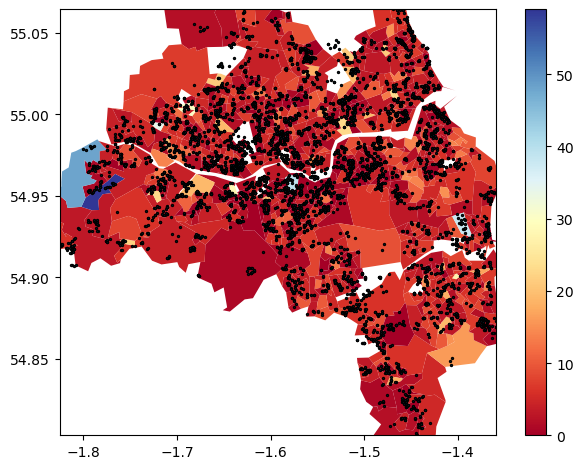

In [70]:
# plotting greenspace on top of the house price map
f, ax = plt.subplots()
# setting the limits of figure to the region level (https://stackoverflow.com/questions/46477018/zooming-and-saving-only-a-central-part-of-interest-in-a-matplotlib-geopandas-fig)
minx, miny, maxx, maxy = region_accesspoints_wgs84.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
lsoas_boundaries_gsclosest.plot(ax=ax,
                                     column="travel_time",
                                     cmap="RdYlBu",
                                     legend=True)
region_accesspoints_wgs84.plot(ax=ax,
                    edgecolor="k", #for yellow
                    markersize=8,
                    marker=".")

plt.tight_layout()

In [71]:
region_accesspoints_wgs84.to_file(os.path.join(data_folder,
                                                     "access_walking_togs.shp"))

NameError: name 'output_folder' is not defined